In [1]:
import pandas as pd
from joblib import dump, load
from src.utils.files import load_dfs
from src.utils.embeddings import retrieve_all_embeds
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from src.models.voting import soft_transform

In [2]:
model_path = "data/models/custom"

In [3]:
df_train, df_dev = load_dfs(["data/train_cleaned_final.csv", "data/dev_cleaned_final.csv"])
embed = retrieve_all_embeds([("data/features/use.pkl.train", "data/features/xception.pkl.train", "data/features/dcca.pkl.train"), 
                             ("data/features/use.pkl.dev","data/features/xception.pkl.dev", "data/features/dcca.pkl.dev"),
                             ("data/features/use.pkl.test", "data/features/xception.pkl.test", "data/features/dcca.pkl.test")])

In [4]:
def plot_confusion_matrix(cm, labels, multilabel=False):
    for i, (k, v) in enumerate(labels.items()):
        data = cm[i] if multilabel else cm
        ax = sns.heatmap(data, xticklabels=v, yticklabels=v, annot=True, fmt="d")
        plt.title(k, fontsize = 20)
        plt.xlabel("y pred", fontsize = 15)
        plt.ylabel("y true", fontsize = 15)
        plt.show()

In [5]:
def plot_confusion_matrices(res, labels, multilabel=False):
    for title, res in res.items():
        print("############### {} ####################".format(title))
        plot_confusion_matrix(res["cm"], labels, multilabel)

In [6]:
def voter_error_analysis(clfs, embeds, y_dev, multilabel, multioutput):
    voter_embed = {**embeds}
    voter_embed.pop("deep cca")
    embed = list(zip(*voter_embed.values()))[1]
    
    y_pred_dev = soft_transform(clfs, embed, multilabel, multioutput)
    
    if multilabel is True:
        conf_mat = multilabel_confusion_matrix(y_dev, y_pred_dev)
    elif multioutput is True:
        conf_mat = [confusion_matrix(y_dev[:,col], y_pred_dev[:,col]) for col in range(y_dev.shape[1])]
    else:
        conf_mat = confusion_matrix(y_dev, y_pred_dev)
    
    return {"y_pred": y_pred_dev, "cm": conf_mat}

In [7]:
def error_analysis(embeds, y_dev, filename, multilabel=False, multioutput=False):
    res = {}
    clfs = []
    for item, (X_train, X_dev, X_test) in embeds.items():
        jobfile = "{}/{}_{}.joblib".format(model_path, filename, "_".join(item.split()))
        clf = load(jobfile)
        if item != "deep cca":
            clfs.append(clf)
        y_pred_dev = clf.predict(X_dev)
        if multilabel is True:
            conf_mat = multilabel_confusion_matrix(y_dev, y_pred_dev)
        elif multioutput is True:
            conf_mat = [confusion_matrix(y_dev[:,col], y_pred_dev[:,col]) for col in range(y_dev.shape[1])]
        else:
            conf_mat = confusion_matrix(y_dev, y_pred_dev)
        res[item] = {"y_pred": y_pred_dev, "cm": conf_mat}
    res["voter"] = voter_error_analysis(clfs, embeds, y_dev, multilabel, multioutput)
    return res

# Error analysis of the models on dev dataset
## Task A

In [8]:
y_dev_a = df_dev["Overall_sentiment"].cat.codes
task_a_labels = {"polarity": ["negative", "neutral", "positive"]}

### KNN

In [9]:
knn_res_a = error_analysis(embed, y_dev_a, "task_a_knn")

############### image only ####################


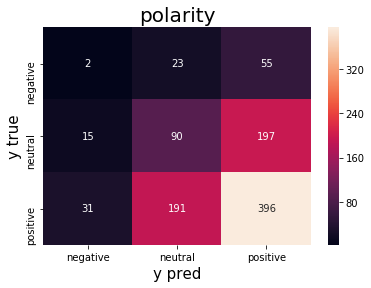

############### text only ####################


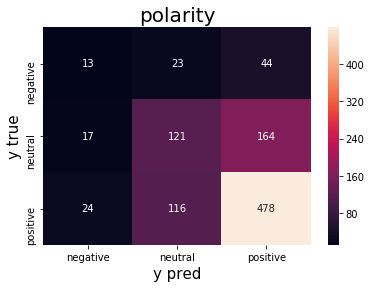

############### deep cca ####################


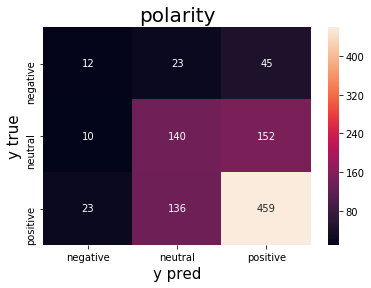

############### concatenated ####################


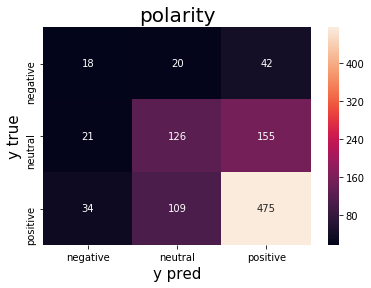

############### voter ####################


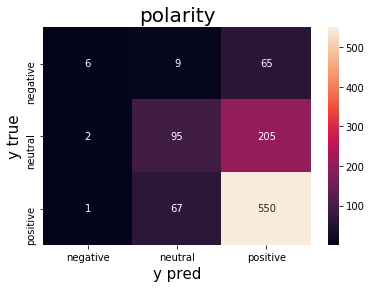

In [10]:
plot_confusion_matrices(knn_res_a, task_a_labels)

### GNB

In [11]:
gnb_res_a = error_analysis(embed, y_dev_a, "task_a_gnb")

############### image only ####################


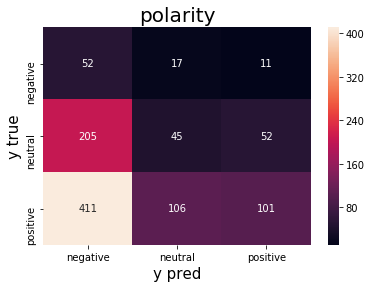

############### text only ####################


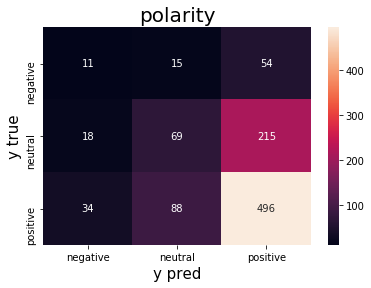

############### deep cca ####################


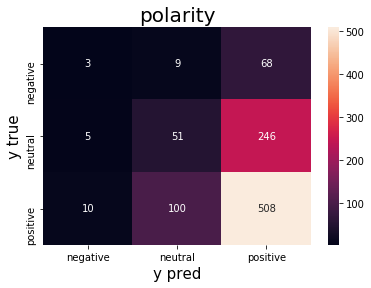

############### concatenated ####################


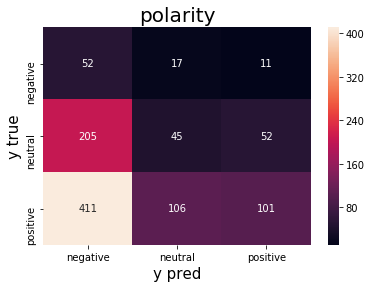

############### voter ####################


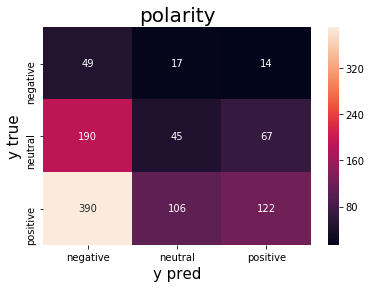

In [12]:
plot_confusion_matrices(gnb_res_a, task_a_labels)

### RF

In [13]:
rf_res_a = error_analysis(embed, y_dev_a, "task_a_rf")

############### image only ####################


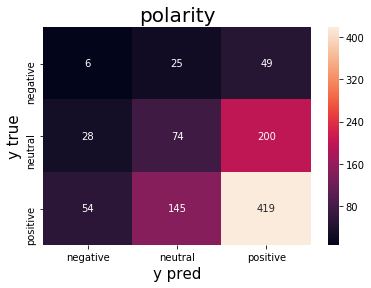

############### text only ####################


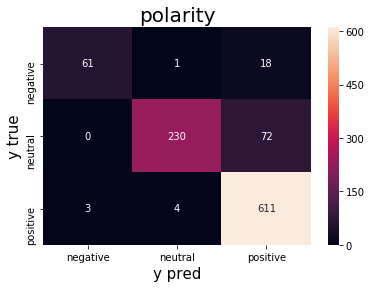

############### deep cca ####################


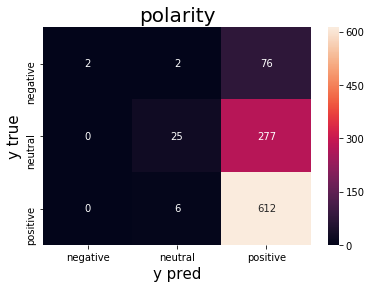

############### concatenated ####################


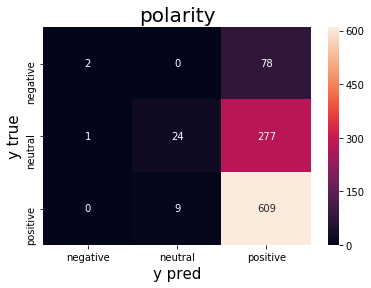

############### voter ####################


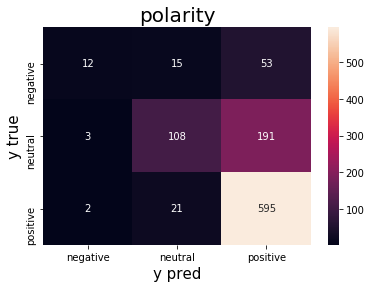

In [14]:
plot_confusion_matrices(rf_res_a, task_a_labels)

### MLP

In [15]:
mlp_res_a = error_analysis(embed, y_dev_a, "task_a_mlp")

############### image only ####################


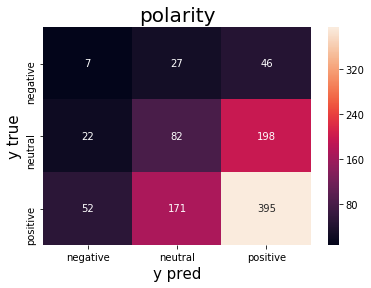

############### text only ####################


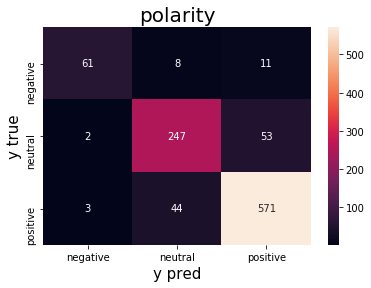

############### deep cca ####################


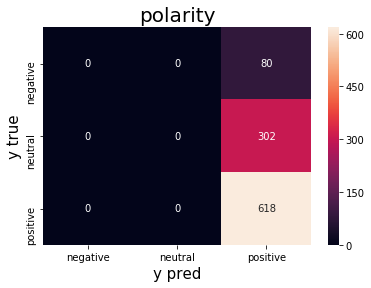

############### concatenated ####################


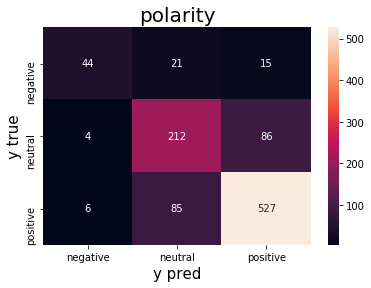

############### voter ####################


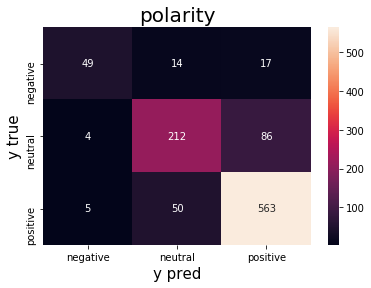

In [16]:
plot_confusion_matrices(mlp_res_a, task_a_labels)

## Task B

In [17]:
y_dev_b = df_dev[["Humour_bin", "Sarcasm_bin", "Offense_bin", "Motivation_bin"]].to_numpy().astype(int)
bin_labels = ["false", "true"]
task_b_labels = {"Humourous": bin_labels, "Sarcastic":bin_labels, "Offensive":bin_labels, "Motivational":bin_labels}

### KNN

In [18]:
knn_res_b = error_analysis(embed, y_dev_b, "task_b_knn", True)

############### image only ####################


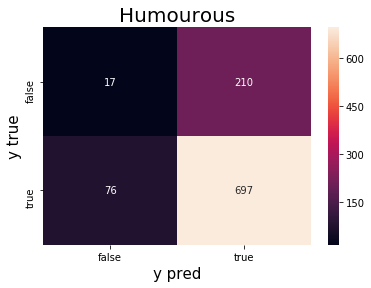

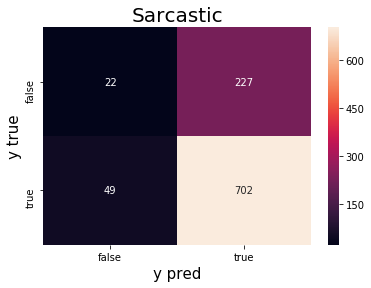

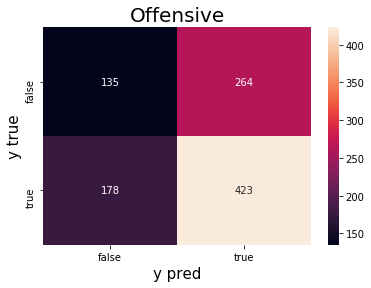

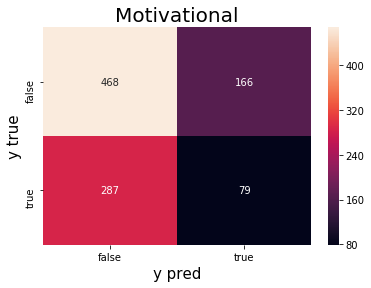

############### text only ####################


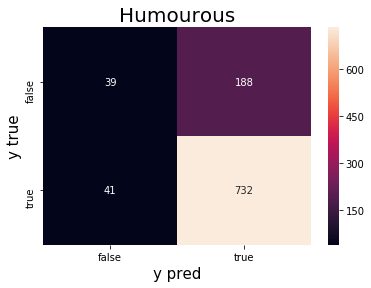

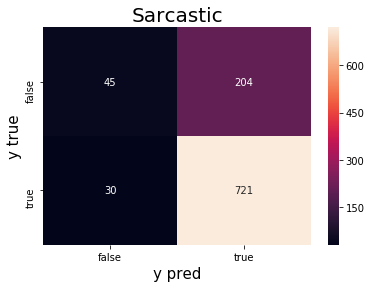

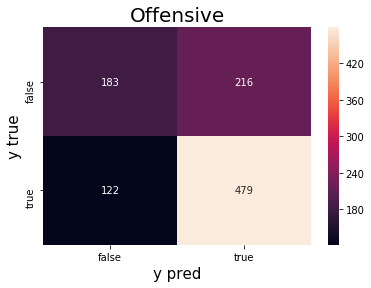

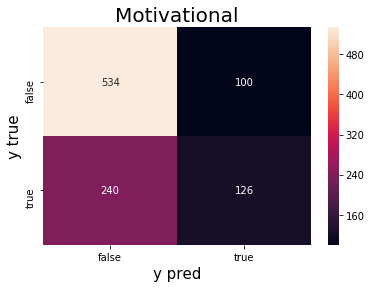

############### deep cca ####################


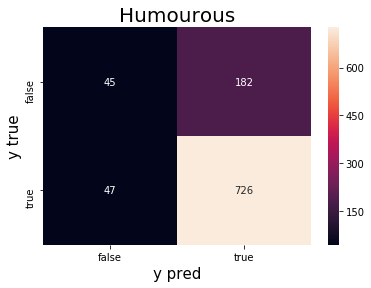

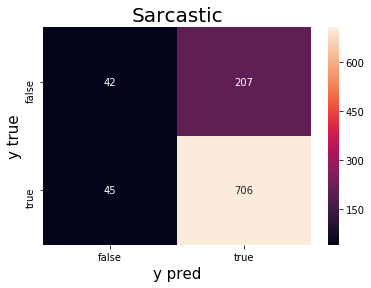

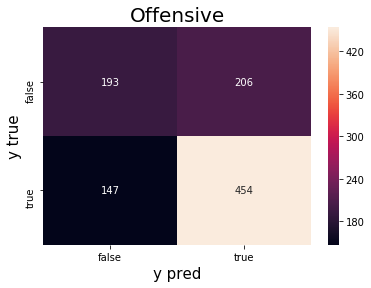

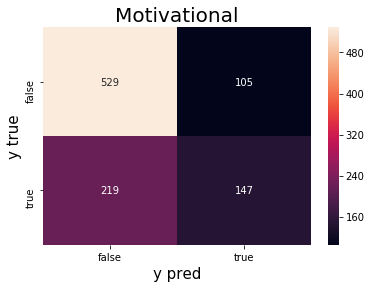

############### concatenated ####################


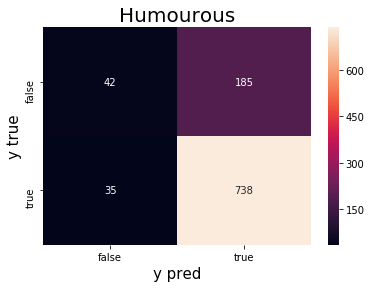

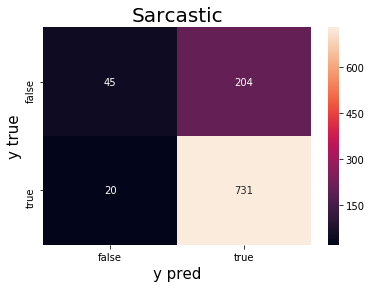

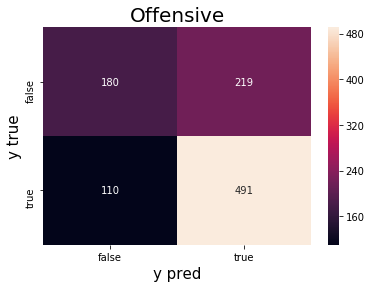

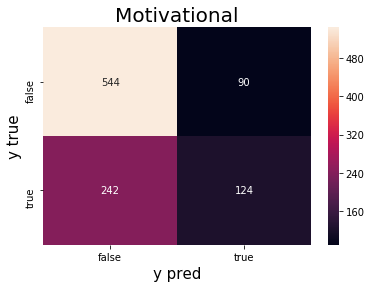

############### voter ####################


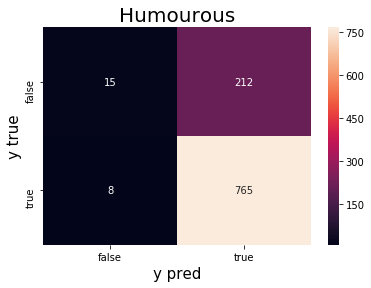

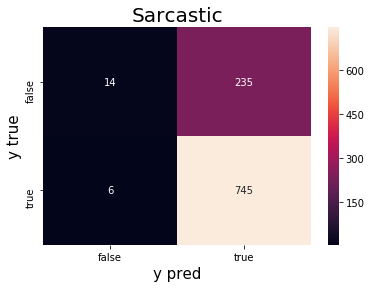

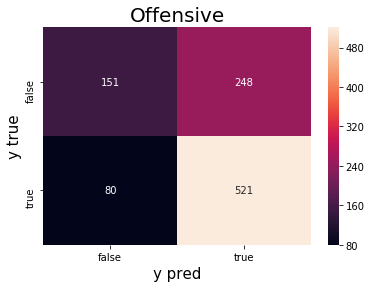

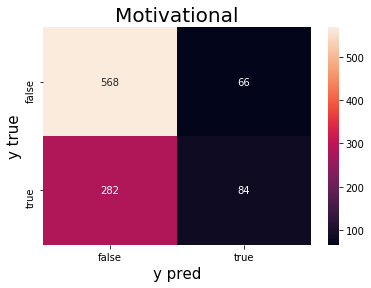

In [19]:
plot_confusion_matrices(knn_res_b, task_b_labels, True)

### GNB

In [20]:
gnb_res_b = error_analysis(embed, y_dev_b, "task_b_gnb", True)

############### image only ####################


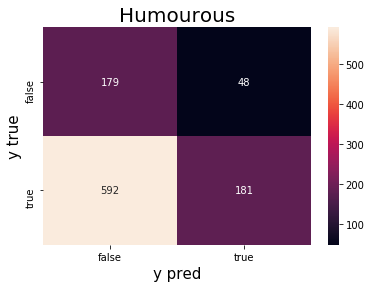

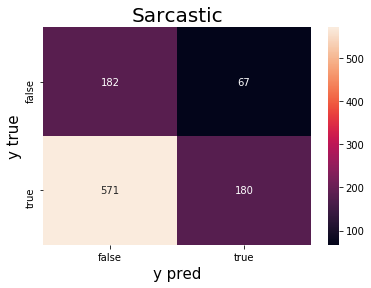

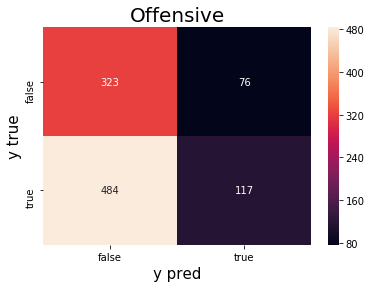

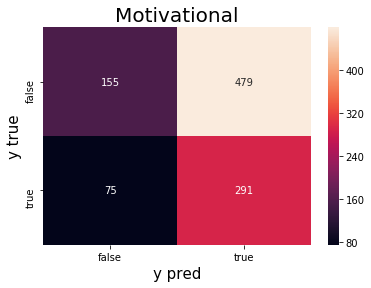

############### text only ####################


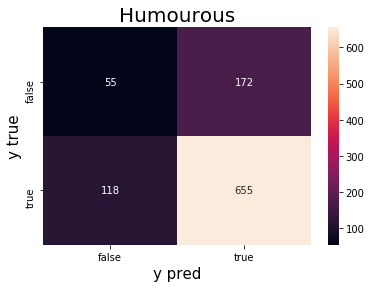

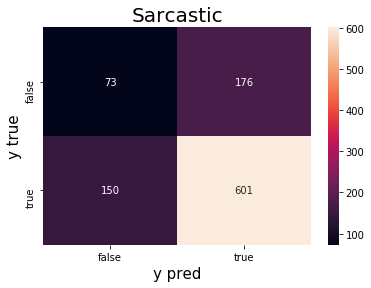

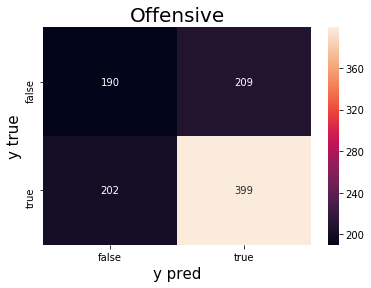

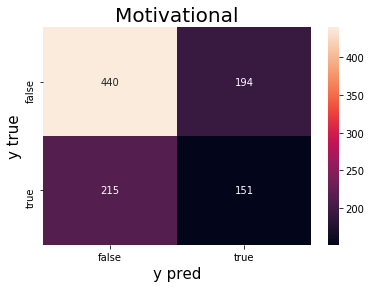

############### deep cca ####################


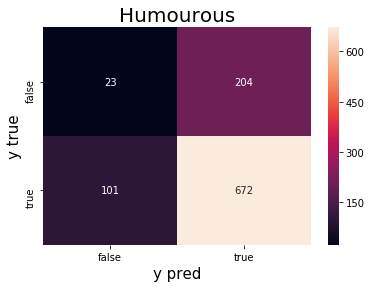

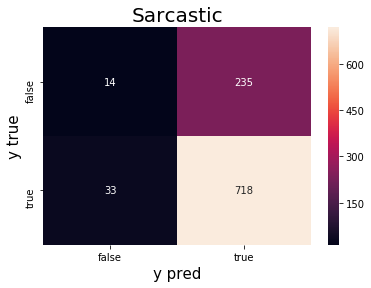

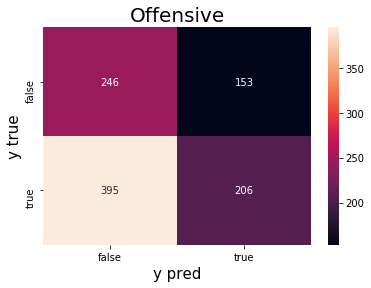

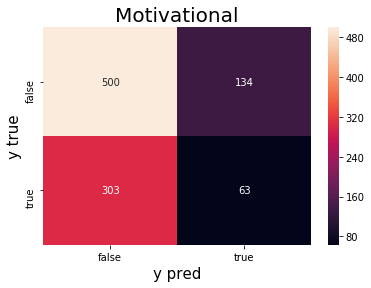

############### concatenated ####################


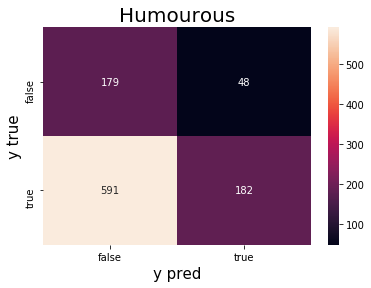

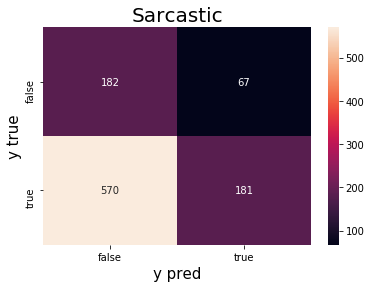

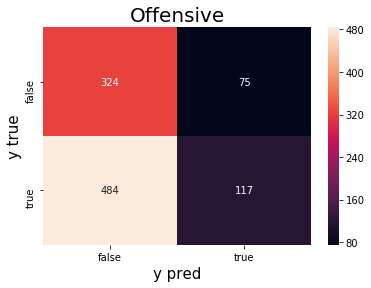

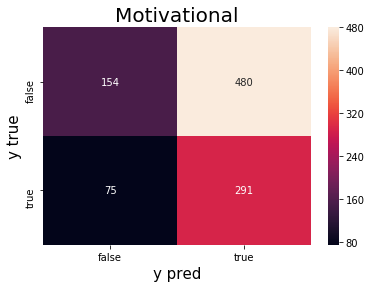

############### voter ####################


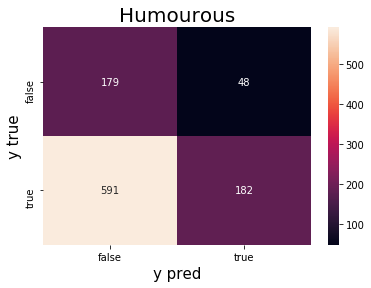

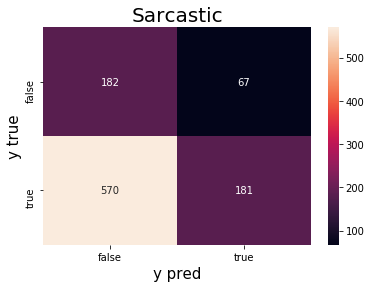

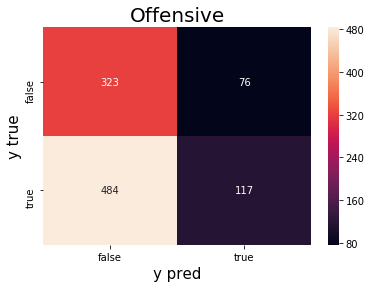

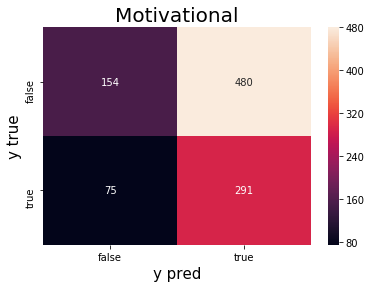

In [21]:
plot_confusion_matrices(gnb_res_b, task_b_labels, True)

### RF

In [22]:
rf_res_b = error_analysis(embed, y_dev_b, "task_b_rf", True)

############### image only ####################


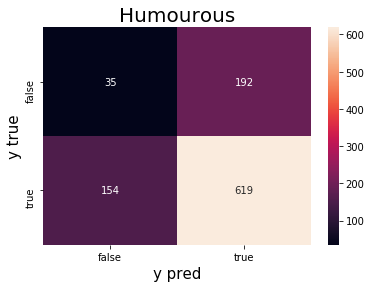

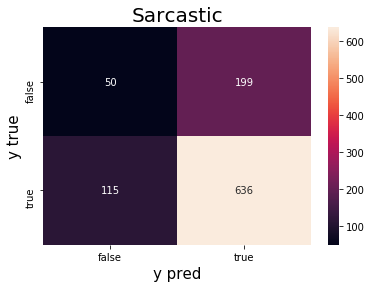

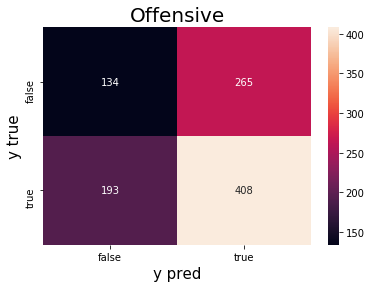

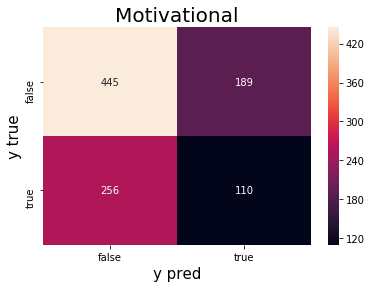

############### text only ####################


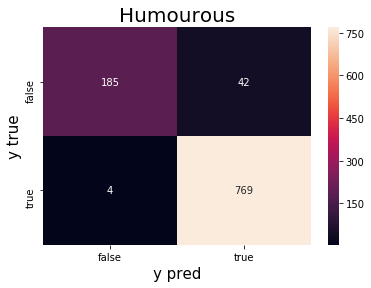

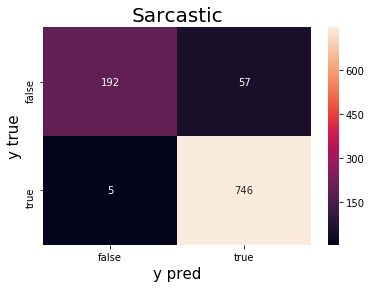

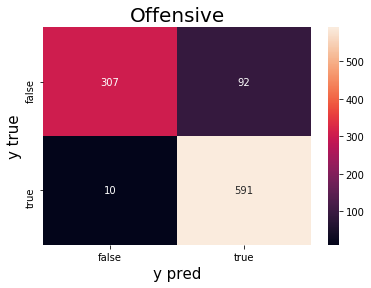

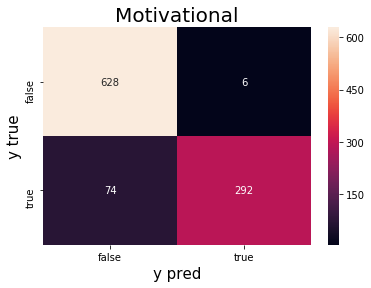

############### deep cca ####################


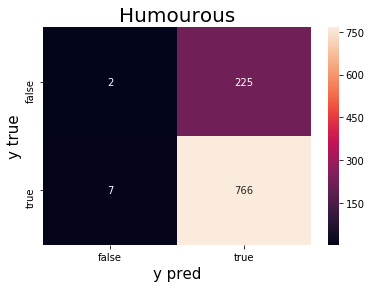

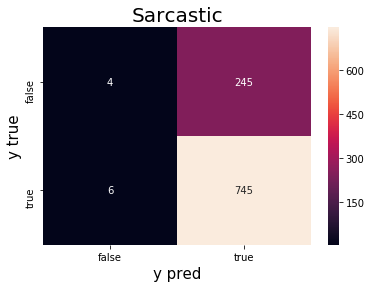

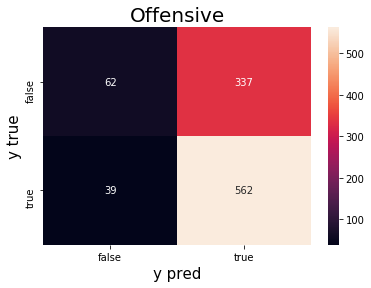

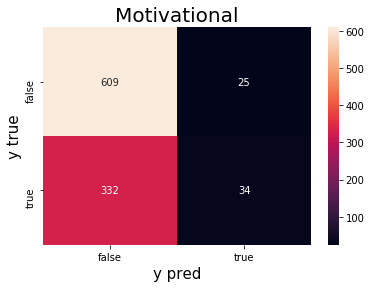

############### concatenated ####################


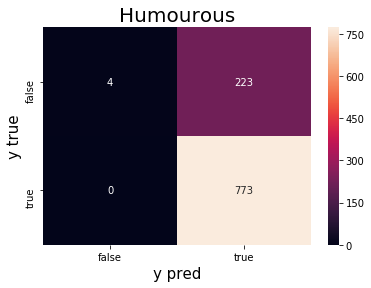

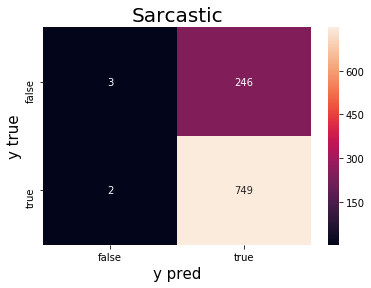

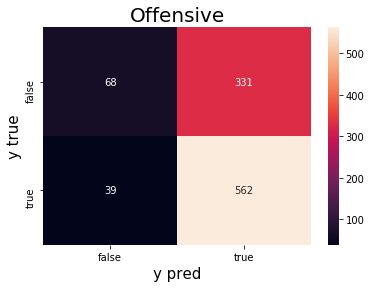

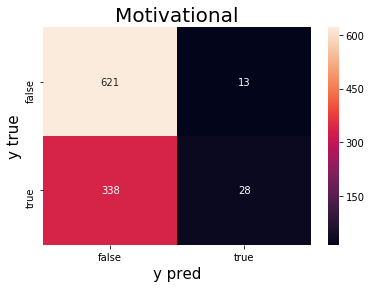

############### voter ####################


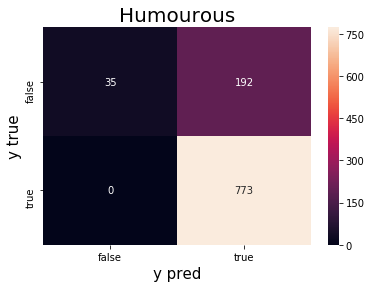

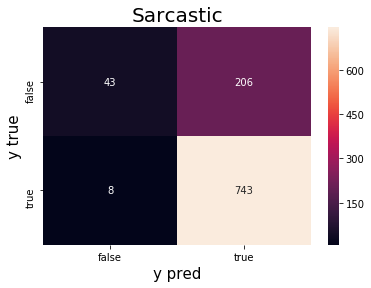

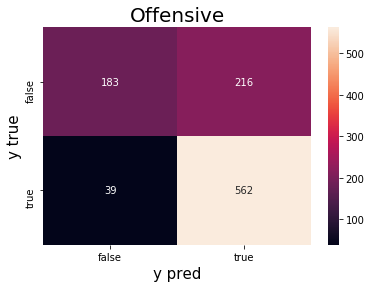

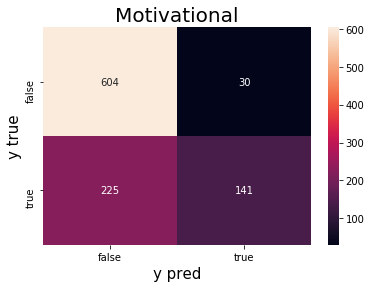

In [23]:
plot_confusion_matrices(rf_res_b, task_b_labels, True)

### MLP

In [24]:
mlp_res_b = error_analysis(embed, y_dev_b, "task_b_mlp", True)

############### image only ####################


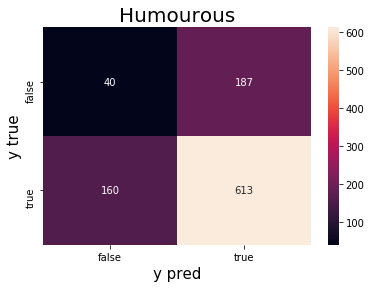

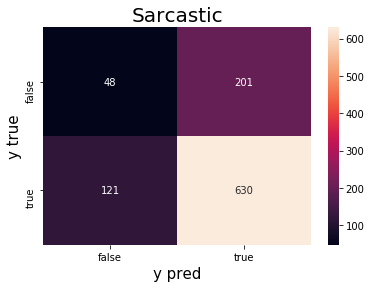

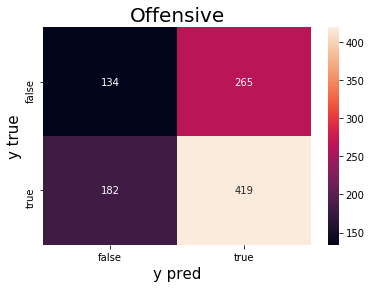

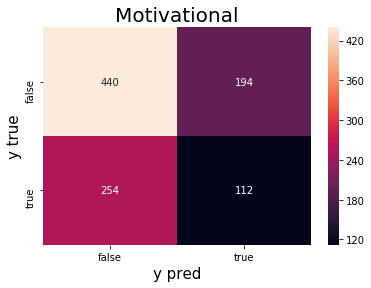

############### text only ####################


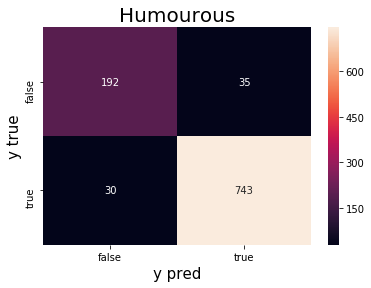

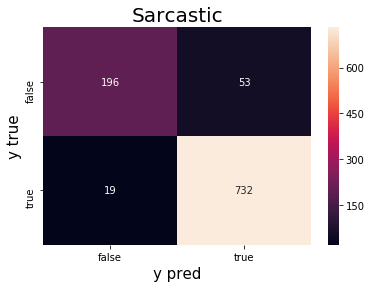

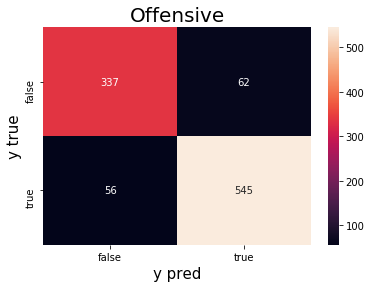

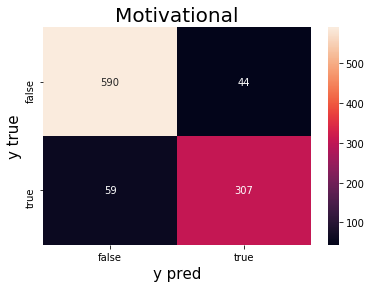

############### deep cca ####################


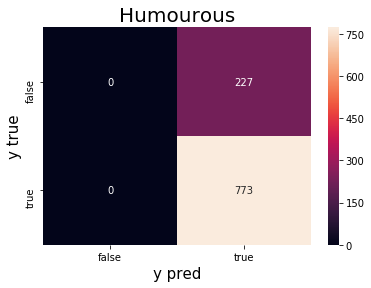

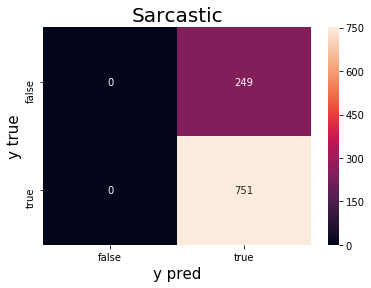

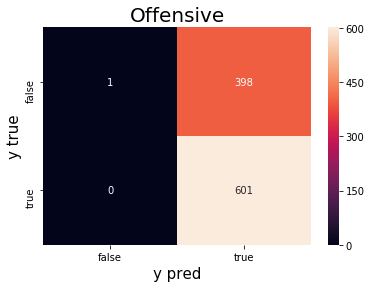

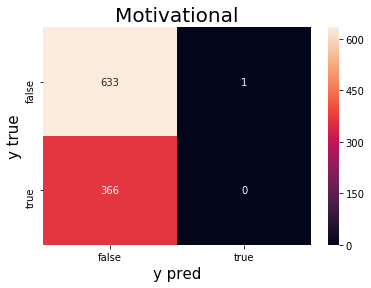

############### concatenated ####################


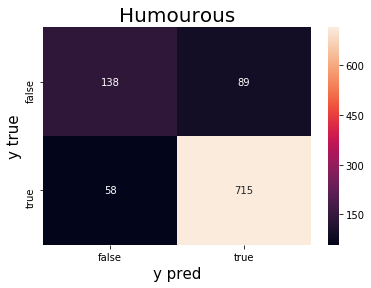

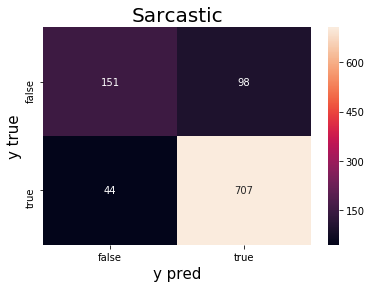

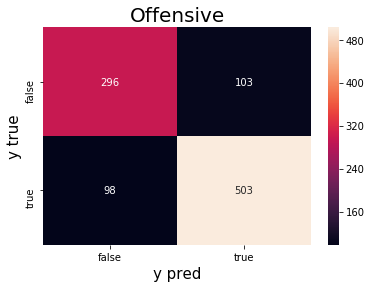

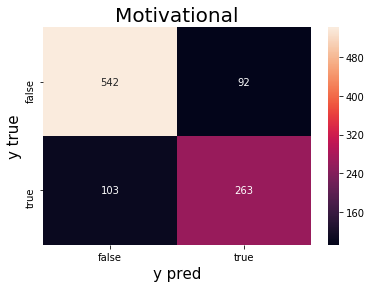

############### voter ####################


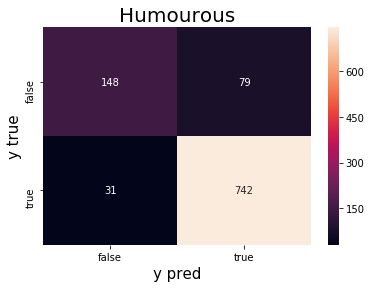

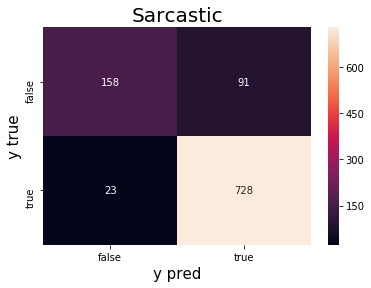

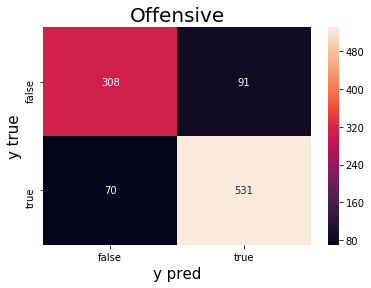

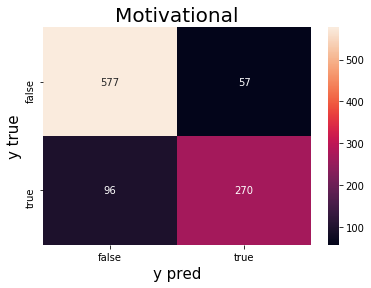

In [25]:
plot_confusion_matrices(mlp_res_b, task_b_labels, True)

## Task C

In [26]:
cols = ["Humour", "Sarcasm", "Offense", "Motivation"]
y_dev_c = pd.concat([df_dev[name].cat.codes for name in cols], axis=1).to_numpy()
bin_labels = ["false", "true"]
scale_labels = ["not at all", "slightly", "mostly", "absolutely"]
task_c_labels = {"Humourous": scale_labels, "Sarcastic":scale_labels, "Offensive":scale_labels, "Motivational":bin_labels}

### KNN

In [27]:
knn_res_c = error_analysis(embed, y_dev_c, "task_c_knn", multioutput=True)

############### image only ####################


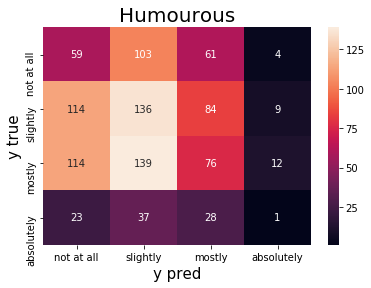

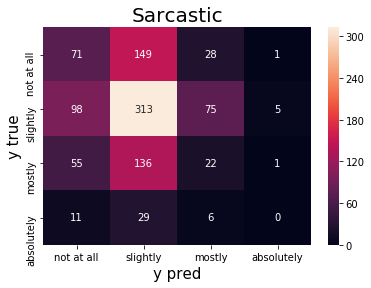

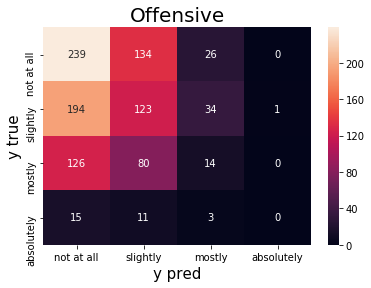

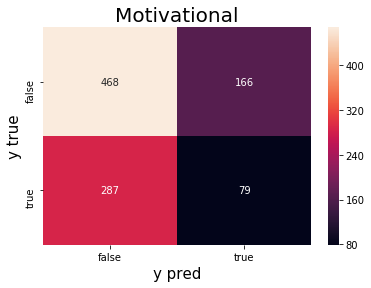

############### text only ####################


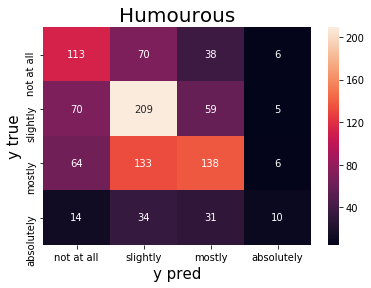

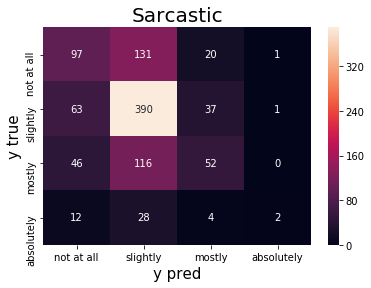

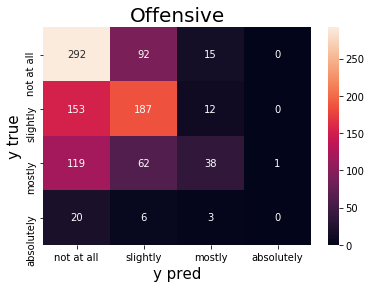

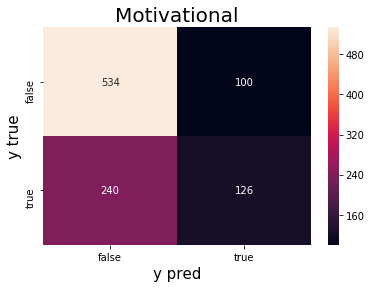

############### deep cca ####################


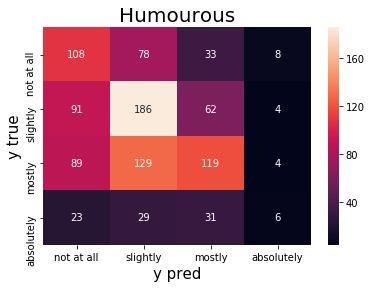

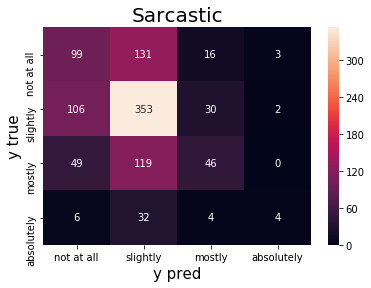

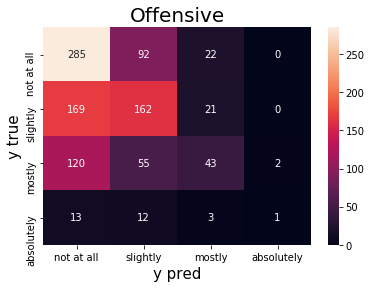

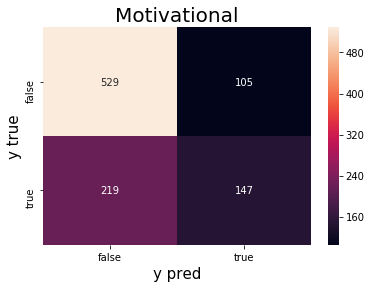

############### concatenated ####################


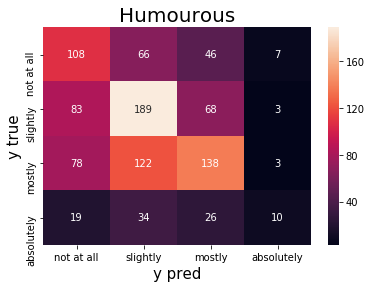

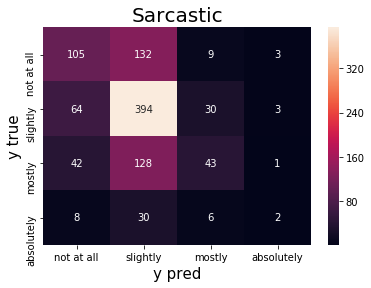

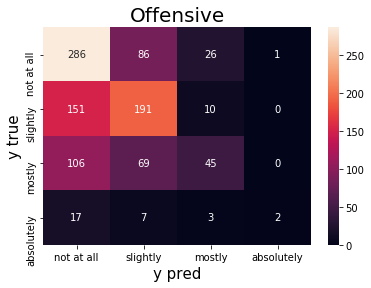

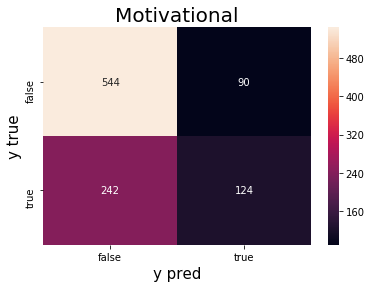

############### voter ####################


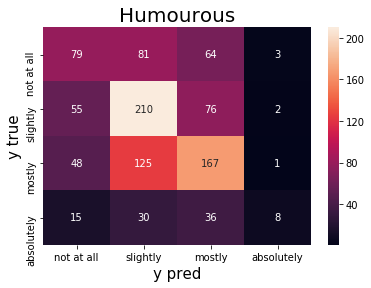

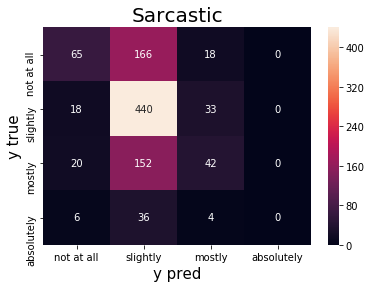

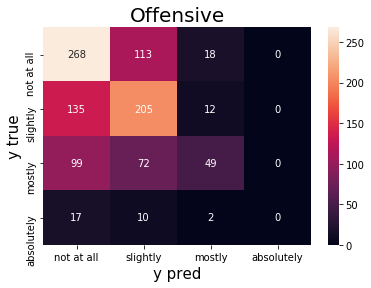

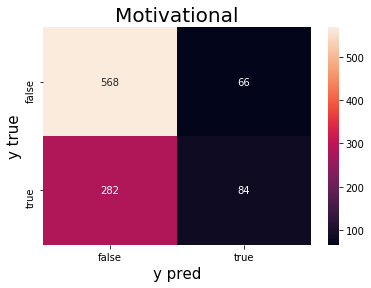

In [28]:
plot_confusion_matrices(knn_res_c, task_c_labels, True)

### GNB

In [29]:
gnb_res_c = error_analysis(embed, y_dev_c, "task_c_gnb", multioutput=True)

############### image only ####################


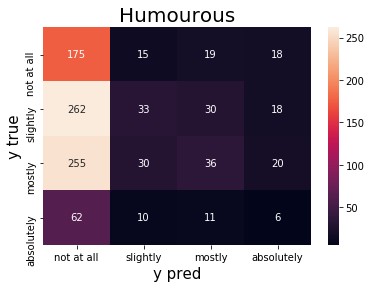

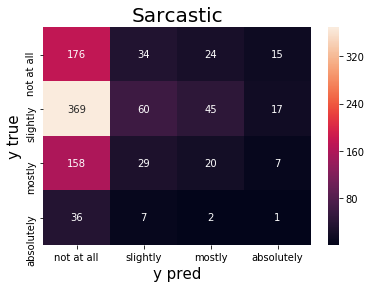

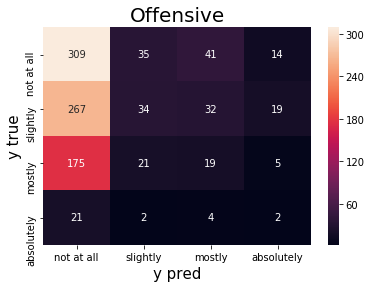

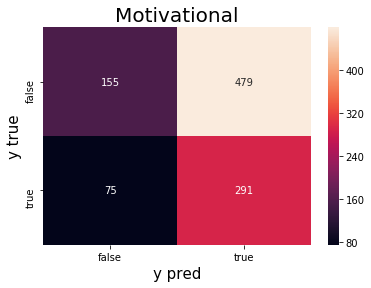

############### text only ####################


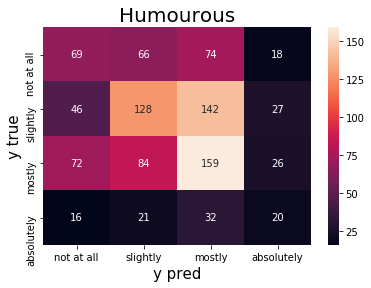

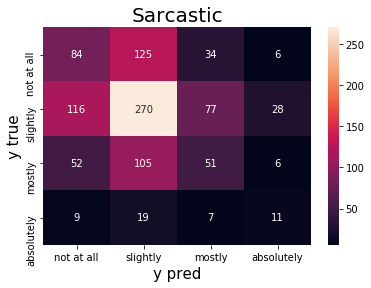

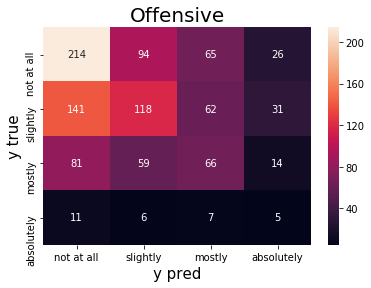

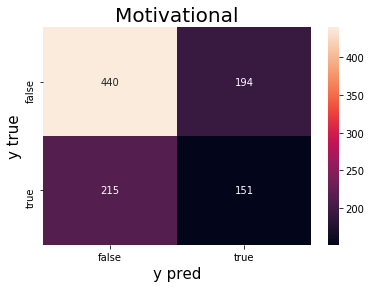

############### deep cca ####################


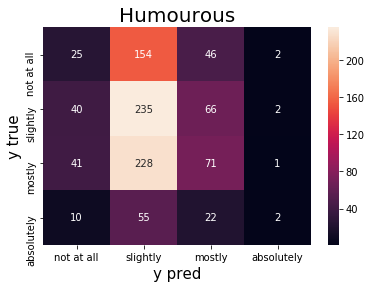

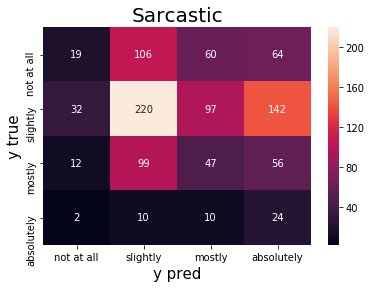

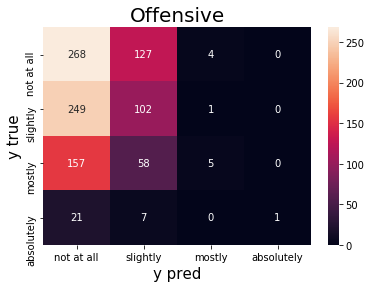

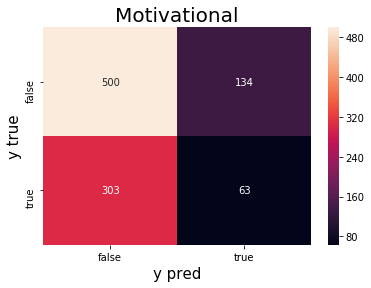

############### concatenated ####################


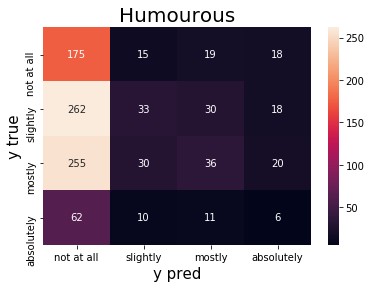

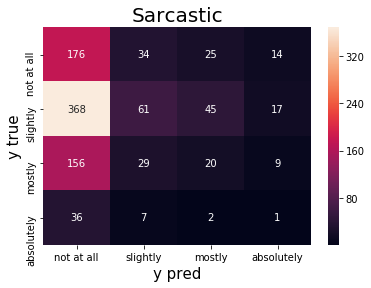

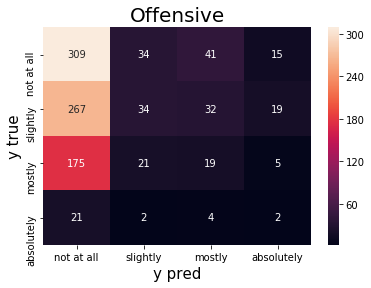

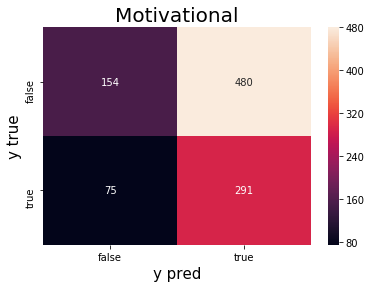

############### voter ####################


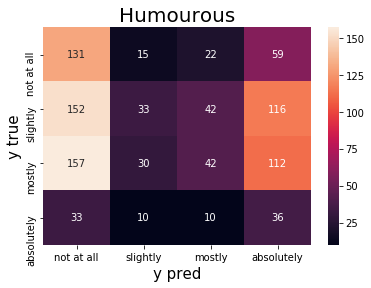

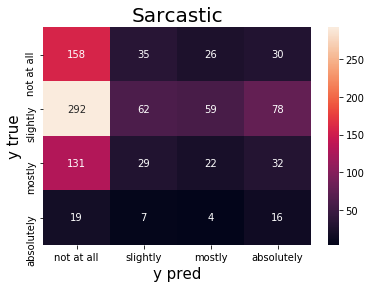

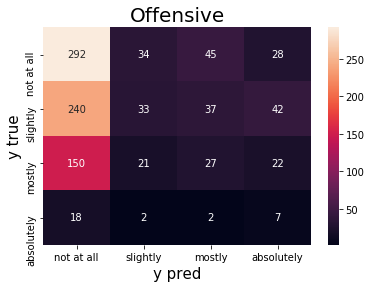

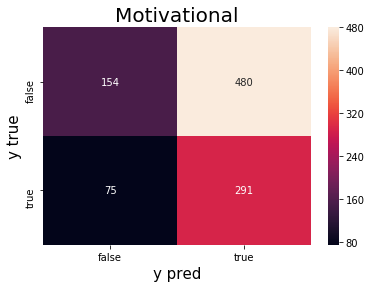

In [30]:
plot_confusion_matrices(gnb_res_c, task_c_labels, True)

### RF

In [31]:
rf_res_c = error_analysis(embed, y_dev_c, "task_c_rf", multioutput=True)

############### image only ####################


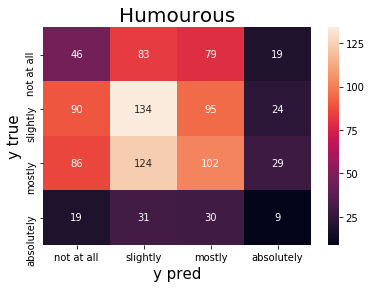

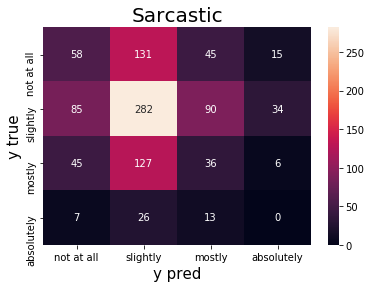

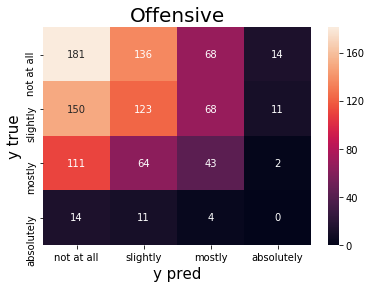

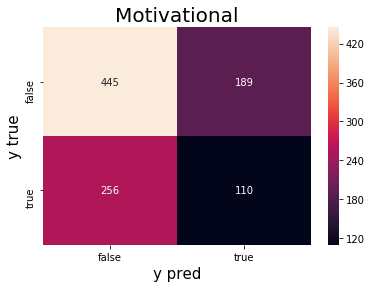

############### text only ####################


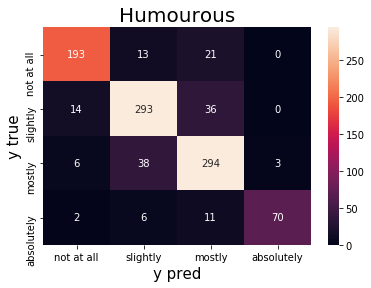

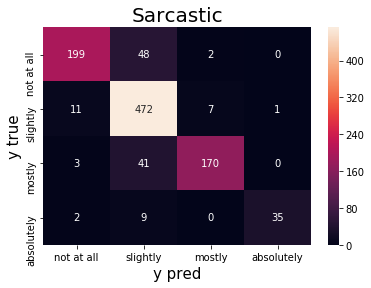

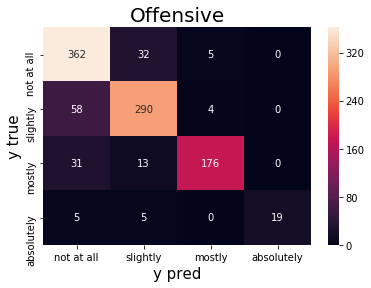

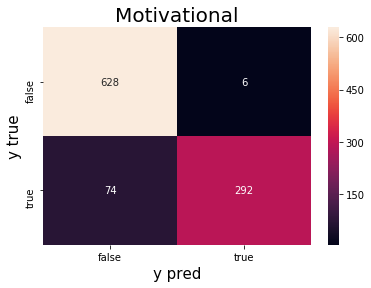

############### deep cca ####################


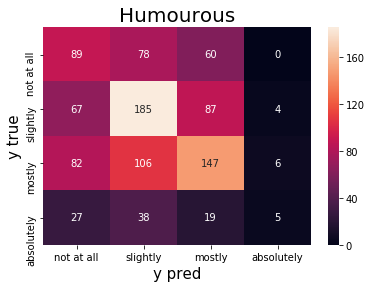

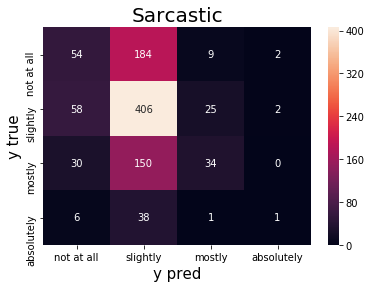

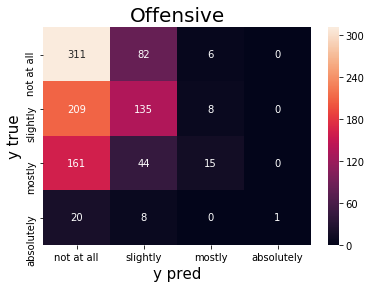

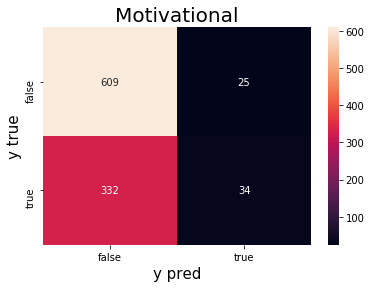

############### concatenated ####################


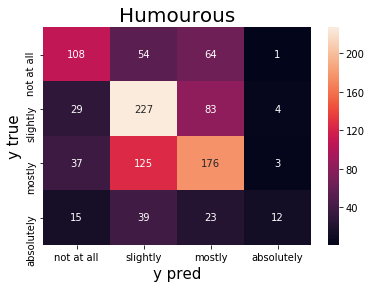

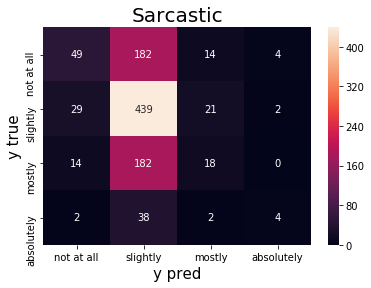

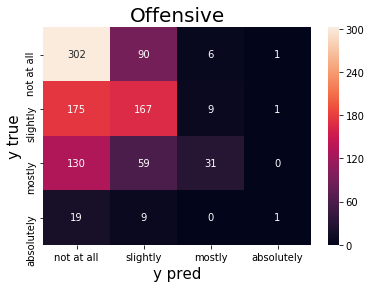

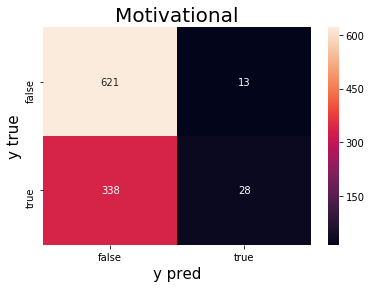

############### voter ####################


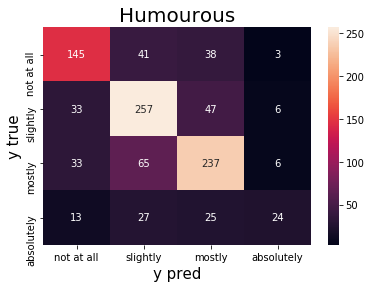

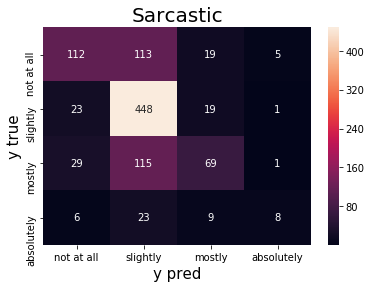

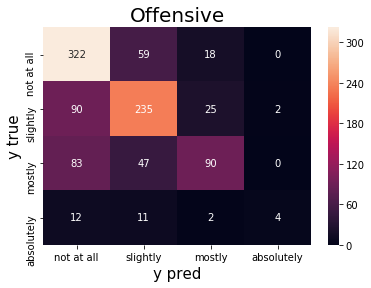

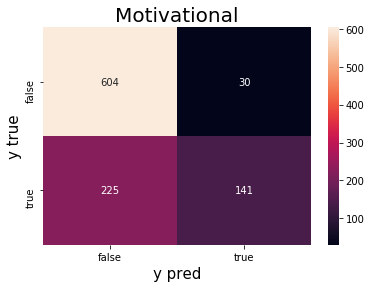

In [32]:
plot_confusion_matrices(rf_res_c, task_c_labels, True)

### MLP

In [33]:
mlp_res_c = error_analysis(embed, y_dev_c, "task_c_mlp", multioutput=True)

############### image only ####################


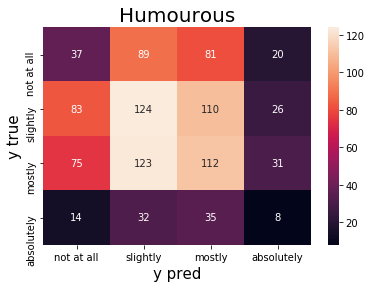

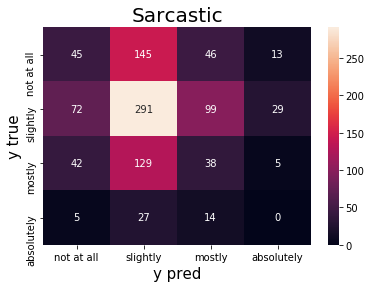

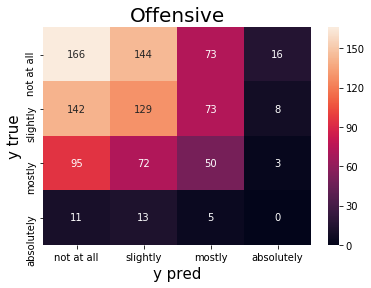

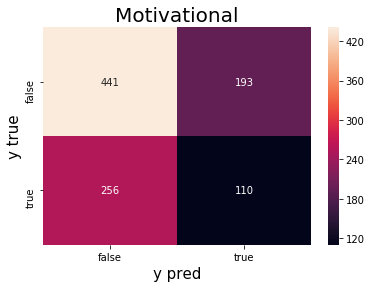

############### text only ####################


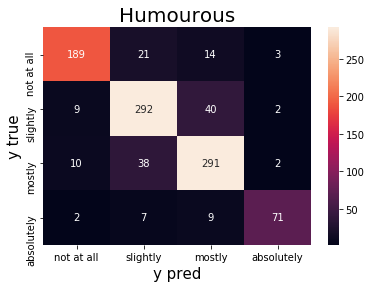

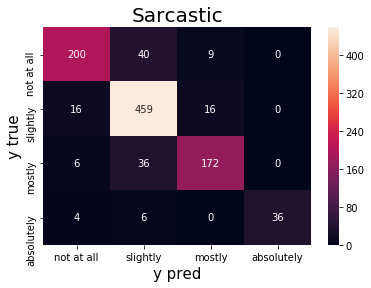

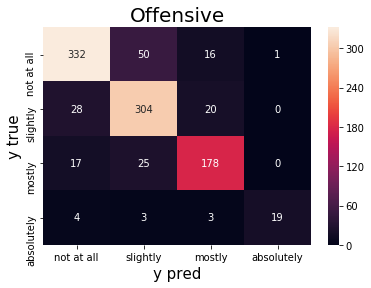

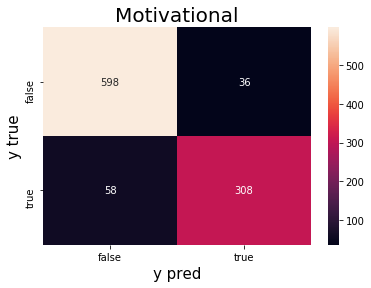

############### deep cca ####################


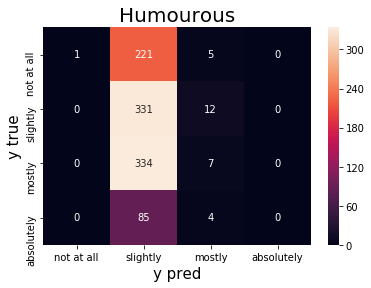

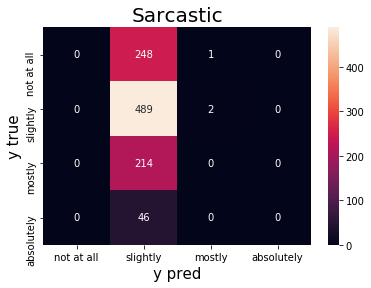

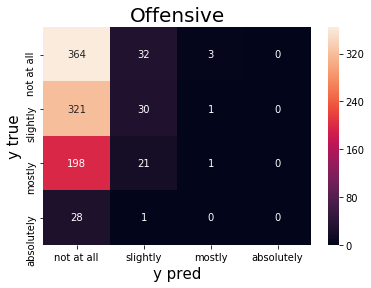

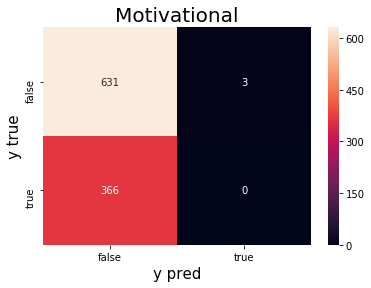

############### concatenated ####################


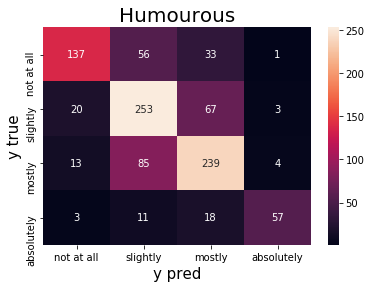

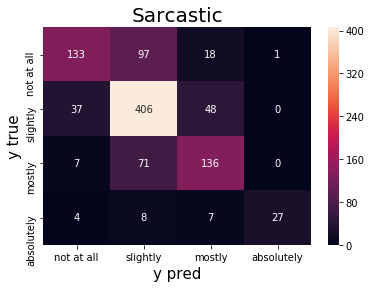

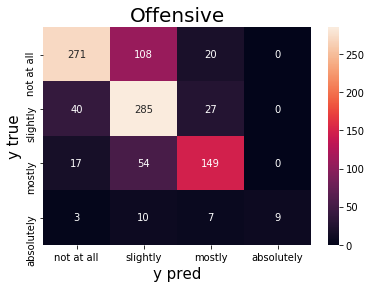

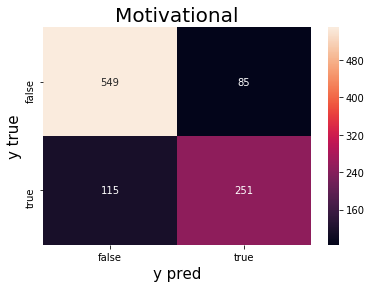

############### voter ####################


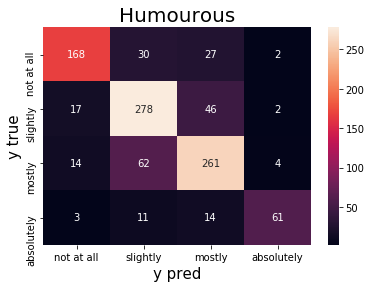

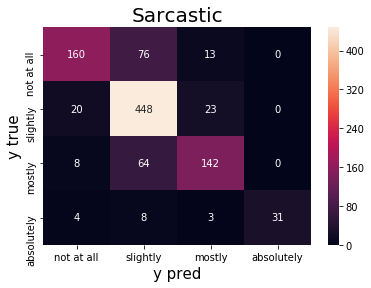

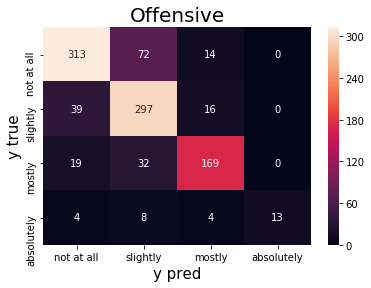

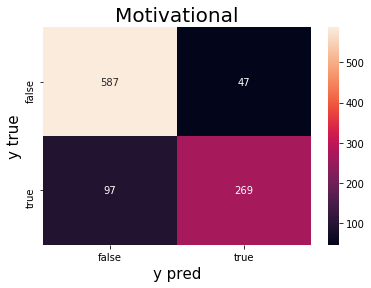

In [34]:
plot_confusion_matrices(mlp_res_c, task_c_labels, True)